Vignette Removal: Not detected. Skipping.
Dehaze: Detected! Showing options for selection...


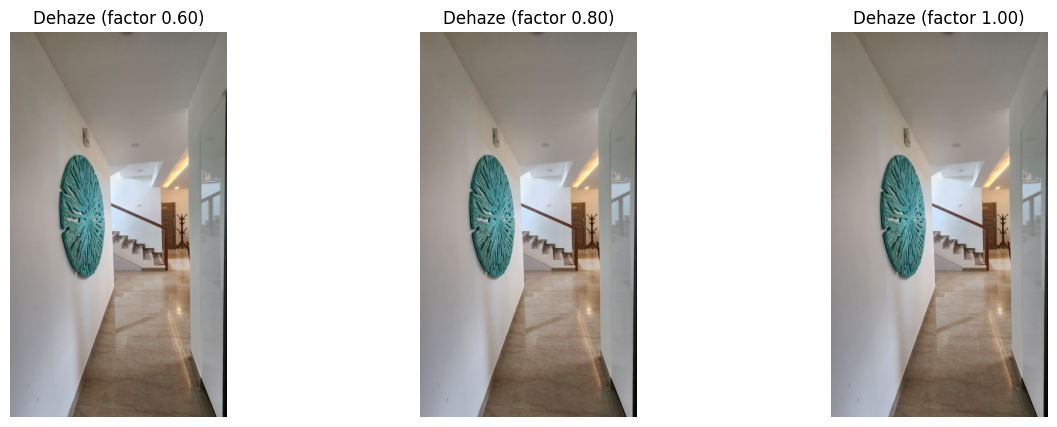

No selection made for Dehaze, using original.
Adjust the Dehaze using slider in the popup window (Press X to skip).
Local Tone Mapping: Detected! Showing options for selection...


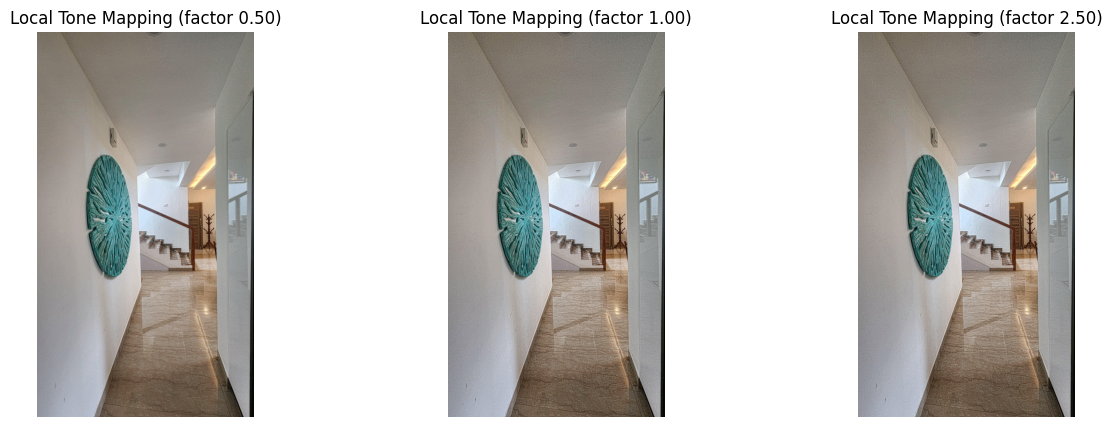

No selection made for Local Tone Mapping, using original.
Adjust the Local Tone Mapping using slider in the popup window (Press X to skip).
Local Tone Mapping: Skipped by user. Passing previous stage output forward.
Color & Style: Detected! Showing options for selection...


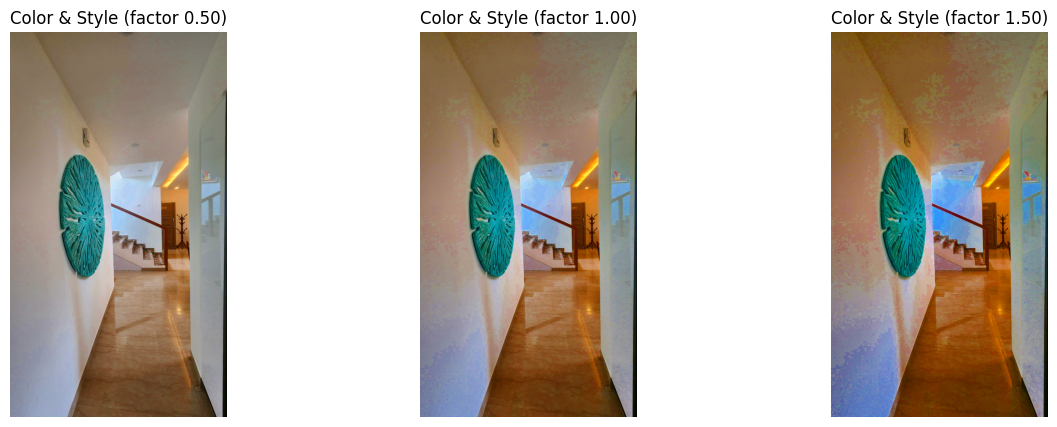

No selection made for Color & Style, using original.
Adjust the Color & Style using slider in the popup window (Press X to skip).
Global Exposure: Detected! Showing options for selection...


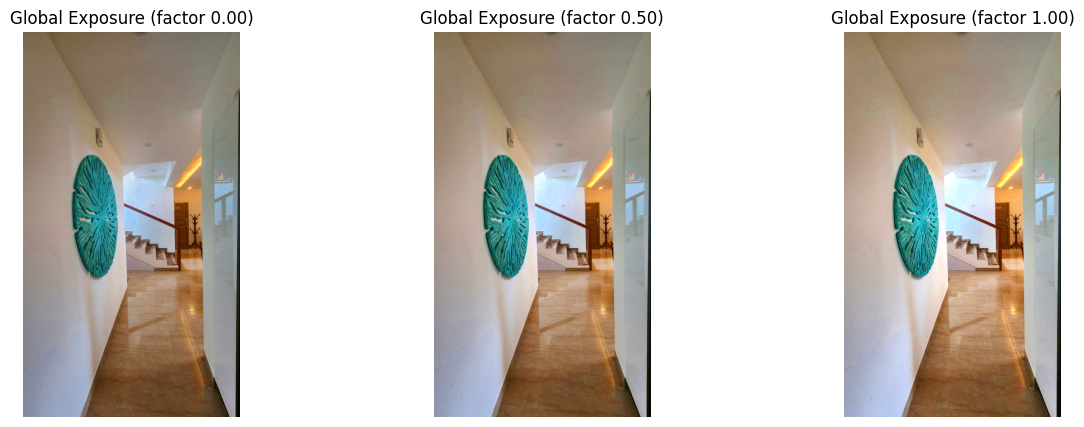

No selection made for Global Exposure, using original.
Adjust the Global Exposure using slider in the popup window (Press X to skip).
White Balance: Not detected. Skipping.


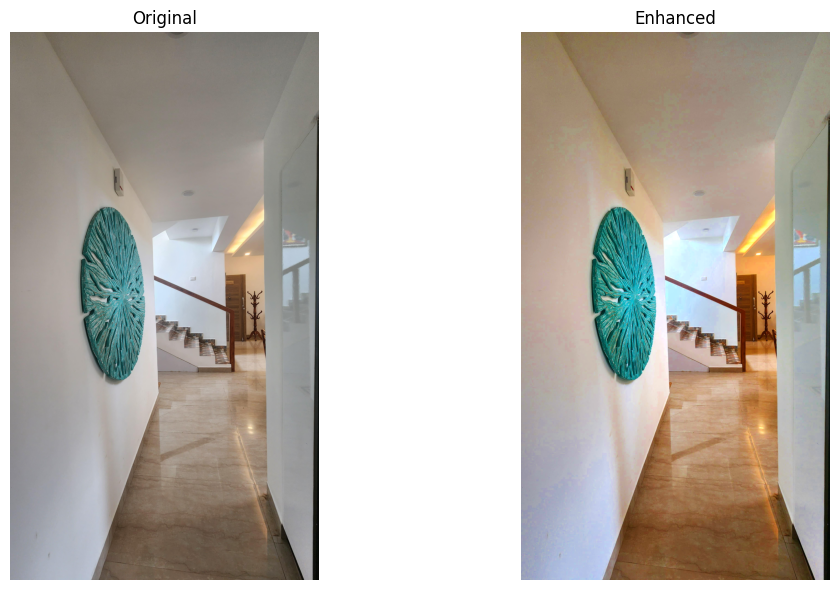

Enhanced image saved at: D:/AutoEnhnace/enhanced\Enhanced_image_Input_25.jpg


In [1]:
import cv2
import numpy as np
import os
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

# === Your existing pipeline functions ===
def display_images(original, enhanced, title_original="Original", title_enhanced="Enhanced"):
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.imshow(original)
    plt.title(title_original)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(enhanced)
    plt.title(title_enhanced)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def detect_vignette(img_bgr, threshold=0.72):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255
    h, w = gray.shape
    center_brightness = np.mean(gray[h//3:2*h//3, w//3:2*w//3])
    corners = [
        np.mean(gray[0:h//5, 0:w//5]),
        np.mean(gray[0:h//5, 4*w//5:w]),
        np.mean(gray[4*h//5:h, 0:w//5]),
        np.mean(gray[4*h//5:h, 4*w//5:w]),
    ]
    corner_brightness = np.mean(corners)
    ratio = corner_brightness / (center_brightness + 1e-8)
    return ratio < threshold

def remove_vignette_with_factor(img_bgr, factor=1.0):
    rows, cols = img_bgr.shape[:2]
    kernel_x = cv2.getGaussianKernel(cols, cols/2)
    kernel_y = cv2.getGaussianKernel(rows, rows/2)
    kernel = kernel_y * kernel_x.T
    mask = kernel / kernel.max()
    
    # scale mask by factor for vignette removal strength
    mask = np.clip(mask * factor, 0.1, 1.0)
    
    result = np.empty_like(img_bgr, dtype=np.float32)
    for i in range(3):
        result[..., i] = img_bgr[..., i] / mask
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

def dark_channel(img, size=15):
    min_img = cv2.min(cv2.min(img[...,0], img[...,1]), img[...,2])
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    dark = cv2.erode(min_img, kernel)
    return dark

def estimate_atmospheric_light(img, dark, top_percent=0.001):
    h, w = dark.shape
    num_pixels = max(1, int(h * w * top_percent))
    flat_img = img.reshape(h*w, 3)
    flat_dark = dark.ravel()
    indices = np.argpartition(flat_dark, -num_pixels)[-num_pixels:]
    atmospheric_light = np.mean(flat_img[indices], axis=0)
    return atmospheric_light

def estimate_transmission(img, atmospheric_light, omega=0.95, size=15):
    norm_img = img / atmospheric_light
    dark = dark_channel(norm_img, size)
    transmission = 1 - omega * dark
    return transmission

def guided_filter_gray(I, p, r, eps):
    mean_I = cv2.boxFilter(I, cv2.CV_32F,(r,r))
    mean_p = cv2.boxFilter(p, cv2.CV_32F,(r,r))
    corr_I = cv2.boxFilter(I*I, cv2.CV_32F,(r,r))
    corr_Ip = cv2.boxFilter(I*p, cv2.CV_32F,(r,r))
    var_I = corr_I - mean_I*mean_I
    cov_Ip = corr_Ip - mean_I*mean_p
    a = cov_Ip/(var_I + eps)
    b = mean_p - a*mean_I
    mean_a = cv2.boxFilter(a, cv2.CV_32F,(r,r))
    mean_b = cv2.boxFilter(b, cv2.CV_32F,(r,r))
    q = mean_a*I + mean_b
    return q

def dehaze(img_bgr, r=60, eps=1e-3, omega=0.95):
    img = img_bgr.astype(np.float32) / 255
    dark = dark_channel(img_bgr)
    A = estimate_atmospheric_light(img_bgr, dark)
    transmission = estimate_transmission(img, A, omega=omega)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255
    transmission_refined = guided_filter_gray(gray, transmission.astype(np.float32), r, eps)
    transmission_refined = np.clip(transmission_refined, 0.1, 1)
    J = np.empty_like(img)
    for c in range(3):
        J[...,c] = (img[...,c] - A[c]/255) / transmission_refined + A[c]/255
    J = np.clip(J, 0, 1)
    dehazed_img = (J * 255).astype(np.uint8)
    return dehazed_img

def local_tone_mapping(img_bgr, radius=15, eps=1e-3, dodge_burn_strength=2.5):
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(img_lab)
    L_float = L.astype(np.float32) / 255.0
    guided = guided_filter_gray(L_float, L_float, radius, eps)
    enhanced_L = L_float + dodge_burn_strength * (L_float - guided)
    enhanced_L = np.clip(enhanced_L, 0, 1)
    enhanced_L_u8 = (enhanced_L * 255).astype(np.uint8)
    enhanced_lab = cv2.merge([enhanced_L_u8, A, B])
    enhanced_bgr = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    return enhanced_bgr

def adjust_saturation_vibrance(img_bgr, saturation_scale=1.3, vibrance_scale=0.5):
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    H, S, V = cv2.split(img_hsv)
    S = S * saturation_scale
    S = np.clip(S, 0, 255)
    vibrance_boost = vibrance_scale * (255 - S) * (S / 255)
    S = S + vibrance_boost
    S = np.clip(S, 0, 255)
    img_hsv_adjusted = cv2.merge([H, S, V]).astype(np.uint8)
    adjusted_bgr = cv2.cvtColor(img_hsv_adjusted, cv2.COLOR_HSV2BGR)
    return adjusted_bgr

def is_image_dull(image_path, brightness_thresh=110, contrast_thresh=50):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean_brightness = np.mean(gray)
    contrast = np.std(gray)
    return not ((mean_brightness > brightness_thresh) and (contrast > contrast_thresh))

def gentle_enhance(pil_img):
    pil_img = ImageEnhance.Contrast(pil_img).enhance(1.11)
    pil_img = ImageEnhance.Sharpness(pil_img).enhance(1.65)
    pil_img = ImageEnhance.Brightness(pil_img).enhance(1.01)
    return pil_img

def dull_enhance(pil_img):
    pil_img = ImageEnhance.Sharpness(pil_img).enhance(2.0)
    pil_img = ImageEnhance.Contrast(pil_img).enhance(1.01)
    pil_img = ImageEnhance.Brightness(pil_img).enhance(1.01)
    return pil_img

def find_dominant_colors(img_bgr, k=4):
    data = img_bgr.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 40, 0.2)
    _, labels, palette = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    _, counts = np.unique(labels, return_counts=True)
    dominant_colors = palette.astype(int)
    percentages = counts / counts.sum()
    sorted_idx = np.argsort(percentages)[::-1]
    dominant_colors = dominant_colors[sorted_idx]
    percentages = percentages[sorted_idx]
    return dominant_colors, percentages

def is_image_type_white_dominant(img_bgr, white_rgb_thresh=240, min_frac=0.2):
    dominant_colors, percentages = find_dominant_colors(img_bgr, k=4)
    for color, frac in zip(dominant_colors, percentages):
        if np.all(color >= white_rgb_thresh) and frac >= min_frac:
            return True
    return False

def white_balance_perfect_reflector(img_bgr, percentile=95):
    img = img_bgr.astype(np.float32)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    thresh = np.percentile(gray, percentile)
    mask = gray >= thresh
    if np.count_nonzero(mask) == 0:
        return img_bgr
    avg_b = np.mean(img[..., 0][mask])
    avg_g = np.mean(img[..., 1][mask])
    avg_r = np.mean(img[..., 2][mask])
    scale_b = 255.0 / avg_b
    scale_g = 255.0 / avg_g
    scale_r = 255.0 / avg_r
    img[..., 0] *= scale_b
    img[..., 1] *= scale_g
    img[..., 2] *= scale_r
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def adjust_blue_cast(img_bgr, intensity=0.1):
    img = img_bgr.astype(np.float32)
    img[..., 0] *= (1 - intensity)
    img[..., 1] *= (1 + intensity / 2)
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def save_enhanced(enhanced_img, image_path):
    save_dir = r'D:/AutoEnhnace/enhanced'
    os.makedirs(save_dir, exist_ok=True)
    fname = os.path.basename(image_path)
    save_path = os.path.join(save_dir, f"Enhanced_image_{fname}")
    enhanced_img.save(save_path)
    print(f"Enhanced image saved at: {save_path}")

# === Helper functions for interactivity === 
def display_images_with_titles(img_list, titles):
    clicked_index = []
    fig, axs = plt.subplots(1, len(img_list), figsize=(5 * len(img_list), 5))
    if len(img_list) == 1:
        axs = [axs]

    for ax, img, title in zip(axs, img_list, titles):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')

    def onclick(event):
        for i, ax in enumerate(axs):
            if ax == event.inaxes:
                clicked_index.append(i)
                plt.close(fig)
                break

    fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()
    return clicked_index[0] if clicked_index else None

def interactive_slider_window(initial_img, adjustment_func, slider_name, slider_max=300, factor_scale=100):
    window_name = f"{slider_name} Adjustment - Press Enter, ESC to Confirm or X to Skip"
    
    def nothing(x):
        pass

    img = initial_img.copy()
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, 400, 300)  # width=400, height=300 (example smaller size)

    cv2.createTrackbar(slider_name, window_name, int(factor_scale), slider_max, nothing)

    adjusted_img = img.copy()
    skip_stage = False
    
    while True:
        pos = cv2.getTrackbarPos(slider_name, window_name)
        factor = pos / factor_scale
        adjusted_img = adjustment_func(img, factor)
        cv2.imshow(window_name, adjusted_img)
        key = cv2.waitKey(1) & 0xFF
        if key == 27 or key == 13:  # ESC or Enter key
            break

        elif key == ord('x') or key == ord('X'):  # User pressed X
            skip_stage = True
            break

    cv2.destroyAllWindows()
    return None if skip_stage else adjusted_img
   

# Stage-specific adjustment functions for slider use
def vignette_adjust_func(img_bgr, factor):
    return remove_vignette_with_factor(img_bgr, factor)

def dehaze_adjust_func(img_bgr, factor):
    omega = 0.6 + 0.4 * np.clip(factor, 0, 1)
    img_float = img_bgr.astype(np.float32) / 255
    dark = dark_channel(img_bgr)
    A = estimate_atmospheric_light(img_bgr, dark)
    transmission = estimate_transmission(img_float, A, omega=omega)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255
    transmission_refined = guided_filter_gray(gray, transmission.astype(np.float32), r=60, eps=1e-3)
    transmission_refined = np.clip(transmission_refined, 0.1, 1)
    J = np.empty_like(img_float)
    for c in range(3):
        J[..., c] = (img_float[..., c] - A[c]/255) / transmission_refined + A[c]/255
    J = np.clip(J, 0, 1)
    dehazed_img = (J * 255).astype(np.uint8)
    return dehazed_img

def local_tone_adjust_func(img_bgr, factor):
    dodge_burn_strength = 0.5 + 4.5 * np.clip(factor, 0, 1)
    return local_tone_mapping(img_bgr, dodge_burn_strength=dodge_burn_strength)

def color_style_adjust_func(img_bgr, factor):
    saturation_scale = 1.0 + factor
    vibrance_scale = factor * 1.0
    return adjust_saturation_vibrance(img_bgr, saturation_scale=saturation_scale, vibrance_scale=vibrance_scale)

def global_exposure_adjust_func(pil_img, factor):
    enhancer = ImageEnhance.Brightness(pil_img)
    return enhancer.enhance(1.0 + 0.2 * np.clip(factor, 0, 1))

def white_balance_adjust_func(img_bgr, factor):
    adjusted_img = white_balance_perfect_reflector(img_bgr, percentile=95)
    intensity = 0.05 * np.clip(factor, 0, 1)
    adjusted_img = adjust_blue_cast(adjusted_img, intensity=intensity)
    return adjusted_img

# Wizard helper function for each stage
def interactive_stage(img_bgr, pil_img, detect_func, generate_func, adjust_func,
                      stage_name, factors, jupyter_display=True):
    detected = detect_func(img_bgr) if detect_func else True
    if not detected:
        print(f"{stage_name}: Not detected. Skipping.")
        return img_bgr, pil_img
    
    print(f"{stage_name}: Detected! Showing options for selection...")
    option_images = [generate_func(img_bgr, f) for f in factors]
    titles = [f"{stage_name} (factor {f:.2f})" for f in factors]

    selected_idx = display_images_with_titles(option_images, titles)
    if selected_idx is None:
        print(f"No selection made for {stage_name}, using original.")
        selected_img = img_bgr
    else:
        selected_img = option_images[selected_idx]

    print(f"Adjust the {stage_name} using slider in the popup window (Press X to skip).")
    adjusted_img = interactive_slider_window(selected_img, adjust_func, slider_name=stage_name, slider_max=300)

    if adjusted_img is None:  # user skipped
        print(f"{stage_name}: Skipped by user. Passing previous stage output forward.")
        return img_bgr, pil_img
    
    
    pil_adjusted = Image.fromarray(cv2.cvtColor(adjusted_img, cv2.COLOR_BGR2RGB))
    return adjusted_img, pil_adjusted

# === Main full pipeline integrating wizard interaction ===
def enhance_and_show_full_pipeline_with_wizards(image_path):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Failed to load image:", image_path)
        return

    pil_original = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

    # Stage 1: Vignette removal
    vignette_factors = [1.0, 1.5, 2.0]
    img_bgr, pil_img = interactive_stage(
        img_bgr, pil_original,
        detect_func=detect_vignette,
        generate_func=remove_vignette_with_factor,
        adjust_func=vignette_adjust_func,
        stage_name="Vignette Removal",
        factors=vignette_factors,
        jupyter_display=True
    )

    # Stage 2: Dehaze
    dehaze_factors = [0.6, 0.8, 1.0]
    img_bgr, pil_img = interactive_stage(
        img_bgr, pil_img,
        detect_func=None,
        generate_func=dehaze_adjust_func,
        adjust_func=dehaze_adjust_func,
        stage_name="Dehaze",
        factors=dehaze_factors,
        jupyter_display=True
    )

    # Stage 3: Local tone mapping
    local_tone_factors = [0.5, 1.0, 2.5]
    img_bgr, pil_img = interactive_stage(
        img_bgr, pil_img,
        detect_func=None,
        generate_func=local_tone_adjust_func,
        adjust_func=local_tone_adjust_func,
        stage_name="Local Tone Mapping",
        factors=local_tone_factors,
        jupyter_display=True
    )

    # Stage 4: Color & style
    color_style_factors = [0.5, 1.0, 1.5]
    img_bgr, pil_img = interactive_stage(
        img_bgr, pil_img,
        detect_func=None,
        generate_func=color_style_adjust_func,
        adjust_func=color_style_adjust_func,
        stage_name="Color & Style",
        factors=color_style_factors,
        jupyter_display=True
    )

    # Stage 5: Global exposure
    global_exposure_factors = [0.0, 0.5, 1.0]
    def gen_global_expansion(img, factor):
        pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        pil_adj = global_exposure_adjust_func(pil, factor)
        arr = np.array(pil_adj.convert('RGB'))[:, :, ::-1]  # RGB to BGR
        return arr
    def adj_global_exposure(img, factor):
        pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        pil_adj = global_exposure_adjust_func(pil, factor)
        arr = np.array(pil_adj.convert('RGB'))[:, :, ::-1]
        return arr
    img_bgr, pil_img = interactive_stage(
        img_bgr, pil_img,
        detect_func=None,
        generate_func=gen_global_expansion,
        adjust_func=adj_global_exposure,
        stage_name="Global Exposure",
        factors=global_exposure_factors,
        jupyter_display=True
    )

    # Stage 6: White balance
    white_balance_factors = [0.0, 0.5, 1.0]
    def detect_white_balance(img):
        return is_image_type_white_dominant(img)
    img_bgr, pil_img = interactive_stage(
        img_bgr, pil_img,
        detect_func=detect_white_balance,
        generate_func=white_balance_adjust_func,
        adjust_func=white_balance_adjust_func,
        stage_name="White Balance",
        factors=white_balance_factors,
        jupyter_display=True
    )

    # Final display and save
    display_images(pil_original, pil_img, title_original="Original", title_enhanced="Enhanced")
    save_enhanced(pil_img, image_path)

# === Run example ===
if __name__ == "__main__":
    image_path = r"D:/AutoEnhnace/Final_Dataset/Batch1/Interior_Dataset/Input/Input_25.jpg"
    enhance_and_show_full_pipeline_with_wizards(image_path)
